In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *

In [2]:
path =Path("")
path.ls()

[WindowsPath('.ipynb_checkpoints'),
 WindowsPath('Combined_News_DJIA.csv'),
 WindowsPath('data'),
 WindowsPath('data_clas.pkl'),
 WindowsPath('data_lm.pkl'),
 WindowsPath('data_save.pkl'),
 WindowsPath('Dow Jones-Copy1.ipynb'),
 WindowsPath('Dow Jones.ipynb'),
 WindowsPath('FE-520 Project Proposal.docx'),
 WindowsPath('models'),
 WindowsPath('RedditNews.csv'),
 WindowsPath('stocknews.zip'),
 WindowsPath('tweet-preprocessor-0.5.0'),
 WindowsPath('twitter sentiments.ipynb'),
 WindowsPath('upload_DJIA_table.csv')]

In [7]:
df=pd.read_csv("RedditNews.csv")
df.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [8]:
df.shape

(73608, 2)

In [15]:
df2 = pd.read_csv(path/'Combined_News_DJIA.csv')
df2=df2.iloc[:,:2]

In [19]:
df2.shape

(1989, 2)

In [26]:
df.Date.nunique()

2943

In [27]:
x=df.merge(df2,on='Date',how="left")

In [32]:
df_final=x.dropna()

In [104]:
df_final.Label.value_counts()

1.0    26618
0.0    23100
Name: Label, dtype: int64

In [35]:
df.tail()

,Date,News
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."
73607,2008-06-08,"b'Marriage, they said, was reduced to the stat..."


In [5]:
df.shape

(1989, 27)

In [62]:
bs=96

In [37]:
data_lm = (TextList.from_df(df,cols=["News"])
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [38]:
data_lm

TextLMDataBunch;

Train: LabelList (66248 items)
x: LMTextList
xxbos a xxunk - old woman in xxmaj mexico xxmaj city finally received her birth certificate , and died a few hours later . xxmaj trinidad xxmaj xxunk xxmaj xxunk had waited years for proof that she had been born in xxunk .,xxbos xxmaj the president of xxmaj france says if xxmaj brexit won , so can xxmaj donald xxmaj trump,xxbos xxmaj british xxmaj man xxmaj who xxmaj must xxmaj give xxmaj police 24 xxmaj hours ' xxmaj notice of xxmaj sex xxmaj threatens xxmaj hunger xxmaj strike : xxmaj the man is the subject of a sexual risk order despite having never been convicted of a crime .,xxbos xxmaj brazil : xxmaj huge spike in number of police killings in xxmaj rio ahead of xxmaj olympics,xxbos xxmaj facebook wins privacy case , can track any xxmaj belgian it wants : xxmaj does n't matter if xxmaj internet users are logged into xxmaj facebook or not
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (7360 items)
x: LMTextList
xxbos xx

In [63]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [64]:
len(data_lm.vocab.itos)

19312

In [65]:
data_lm.show_batch()

idx,text
0,"must xxmaj give xxmaj police 24 xxmaj hours ' xxmaj notice of xxmaj sex xxmaj threatens xxmaj hunger xxmaj strike : xxmaj the man is the subject of a sexual risk order despite having never been convicted of a crime . xxbos xxmaj brazil : xxmaj huge spike in number of police killings in xxmaj rio ahead of xxmaj olympics xxbos xxmaj facebook wins privacy case , can track any"
1,execute more than 100 people . xxbos xxmaj angela xxmaj merkel strikes deal with xxmaj german states to put brakes on green energy . xxmaj pact addresses concerns that burgeoning output from renewables is putting strain on electricity grid and pushing up prices xxbos xxmaj residents challenge council on sale of 40 billion litres of xxunk water . xxmaj the battle over just who owns our water is being fought
2,"kingdom surrounding recent revelations of extremist anti - xxmaj israel and anti - xxmaj jewish expressions by xxmaj labor members xxbos xxmaj labour suspends three councillors over xxmaj israel comments xxbos xxmaj brazil judge orders whatsapp blocked , affecting 100 million users xxbos xxmaj puerto xxmaj rico says it will default on xxmaj monday xxbos xxmaj leaked papers allege xxup us intimidating xxup eu over xxup ttip free trade deal"
3,"xxmaj using xxmaj adblock xxmaj plus to block ads is legal , rules xxmaj german xxunk the fifth time xxbos xxmaj apple wants the xxup fbi to reveal how it hacked the xxmaj san xxmaj xxunk killer 's iphone xxbos ' xxmaj war on xxmaj drugs ' has made no difference to number of users & & actively harms public health , major study concludes - xxmaj report authors call"
4,trade xxmaj officials xxmaj promised xxmaj exxon xxmaj that xxup ttip xxmaj will xxmaj erase xxmaj environmental ' xxmaj obstacles ' xxmaj worldwide . xxup eu trade officials xxunk the oil giant as it xxunk about new regulations popping up in xxmaj global xxmaj south xxbos xxmaj japan xxmaj census : xxmaj population xxmaj fell xxmaj nearly 1 xxmaj million in 2010 - 15 xxbos xxmaj hussain brothers jailed for


In [66]:

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


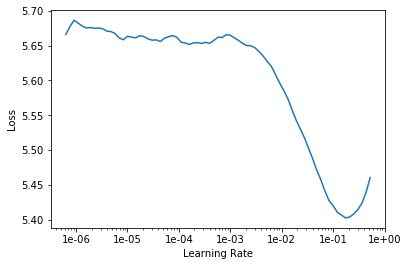

In [67]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [68]:

learn.fit_one_cycle(3, slice(1e-01/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.727415,4.502021,0.278412,00:33
1,4.484428,4.293276,0.294733,00:33
2,4.008314,4.153305,0.305968,00:34


In [69]:

learn.save('fit_head')

In [70]:
learn.load('fit_head');

In [71]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


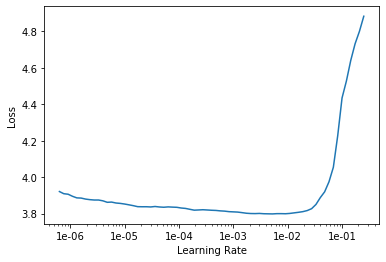

In [72]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [73]:
learn.fit_one_cycle(6, max_lr=slice(1e-05,1e-02), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.780514,4.073951,0.314929,00:40
1,3.754019,4.005801,0.320600,00:40
2,3.635589,3.970162,0.324915,00:40
3,3.471559,3.959110,0.328178,00:40
4,3.317240,3.965709,0.329858,00:40
5,3.218312,3.976300,0.329220,00:40


In [74]:
learn.save('fine_tuned')

In [75]:

learn.load('fine_tuned');

In [76]:
TEXT = "The stock market is"
N_WORDS = 15
N_SENTENCES = 10


In [77]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


The stock market is falling to $ 100 million , making it the richest single country in the world
The stock market is one of the most popular in the world in terms of tax xxbos Why
The stock market is the biggest in the world a decade as two - thirds of foreign Europeans
The stock market is destroying the world 's financial markets . More than half of Europeans are
The stock market is between $ 6 and $ 800 billion xxbos New Zealand 's New
The stock market is struggling to bring more than 130 million notes worth of information to the Central
The stock market is shrinking , and global markets are collapsing xxbos The Amazon 's ' traditional
The stock market is falling below $ 50 billion after mortgage disaster - Telegraph xxbos Police in
The stock market is at about $ 100 million , and a quarter of London 's stock market
The stock market is in China , with a half million fine . Chinese Stock


In [78]:
learn.save_encoder('fine_tuned_enc')

In [124]:
df_final

,Date,News,Label
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,1.0
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,1.0
2,2016-07-01,"The president of France says if Brexit won, so...",1.0
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,1.0
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,1.0
...,...,...,...
72078,2008-08-08,b'Why the Pentagon Thinks Attacking Iran is a ...,0.0
72079,2008-08-08,b'Caucasus in crisis: Georgia invades South Os...,0.0
72080,2008-08-08,b'Indian shoe manufactory - And again in a se...,0.0
72081,2008-08-08,b'Visitors Suffering from Mental Illnesses Ban...,0.0


In [125]:
train=df_final.iloc[:40000,1:]
valid=df_final.iloc[40000:,1:]

In [144]:
dic={1.0:"up_same",0.0:"down"}

In [147]:
train.Label=train.Label.map(dic)

In [148]:
valid.Label=valid.Label.map(dic)

In [149]:
train.Label.value_counts()

up_same    21550
down       18450
Name: Label, dtype: int64

In [150]:
valid.Label.value_counts()

up_same    5068
down       4650
Name: Label, dtype: int64

In [154]:
data_clas = TextDataBunch.from_df(path,train_df=train,valid_df=valid,vocab=data_lm.vocab,text_cols="News",label_cols="Label")

In [155]:
data_clas.show_batch()

text,target
"xxbos b'""the xxmaj pope xxmaj was xxmaj drawn xxmaj directly into the xxmaj roman xxmaj catholic xxmaj sex xxmaj abuse xxmaj scandal for the xxmaj first xxmaj time xxmaj tonight as xxmaj news xxmaj emerged of xxmaj his xxmaj part in a xxmaj decision to xxmaj send a xxmaj paedophile xxmaj priest for xxmaj therapy . xxmaj the xxmaj priest xxmaj went on to xxmaj xxunk and xxmaj was xxmaj",up_same
"xxbos xxmaj bill xxmaj gates has told the the xxup bbc that the xxmaj united xxmaj states "" should set a better example "" by taking in more refugees . xxmaj speaking to the xxup bbc at the xxmaj world xxmaj economic xxmaj forum in xxmaj davos , xxmaj mr xxmaj gates said his home country "" had the capacity "" to follow the examples of xxmaj germany and xxmaj",up_same
"xxbos "" xxmaj jews and xxmaj israelis , or passengers carrying any non - xxmaj islamic article of faith , will not be able to fly code - share flights from the xxup u.s. to xxmaj saudi xxmaj arabia under xxmaj delta xxmaj air xxmaj line 's new partnership with xxmaj saudi xxmaj arabian xxmaj airlines that is set to begin in 2012 ... xxmaj religious items such as xxmaj",down
"xxbos \r \n \r \n \r \n xxmaj divers xxmaj return to xxmaj wreck xxmaj where xxmaj ancient xxmaj computer xxmaj found - xxmaj in 1900 , divers saw "" a pile of dead , naked women "" on the seabed . xxmaj turned out to be xxmaj greek statues in a xxmaj roman ship wreck . xxmaj also found was a curious device that calculates movements of stars",up_same
"xxbos xxmaj muhammad xxmaj xxunk lost his mother , his wife , a sister - in - law , a brother , a nephew , his four daughters and two of his sons in last week 's mass shooting in two villages . "" xxmaj like anyone , i wanted my children to be doctors , engineers important people . xxmaj all my dreams are buried under a pile of",down


In [156]:
data_clas.batch_size=64

In [157]:
data_clas.save('data_clas.pkl')

In [158]:
data_clas.train_ds.c

2

In [159]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,).to_fp16()
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (40000 items)
x: TextList
xxbos a xxunk - old woman in xxmaj mexico xxmaj city finally received her birth certificate , and died a few hours later . xxmaj trinidad xxmaj xxunk xxmaj xxunk had waited years for proof that she had been born in xxunk .,xxbos xxup imf chief backs xxmaj athens as permanent xxmaj olympic host,xxbos xxmaj the president of xxmaj france says if xxmaj brexit won , so can xxmaj donald xxmaj trump,xxbos xxmaj british xxmaj man xxmaj who xxmaj must xxmaj give xxmaj police 24 xxmaj hours ' xxmaj notice of xxmaj sex xxmaj threatens xxmaj hunger xxmaj strike : xxmaj the man is the subject of a sexual risk order despite having never been convicted of a crime .,xxbos 100 + xxmaj nobel laureates urge xxmaj greenpeace to stop opposing gmos
y: CategoryList
up_same,up_same,up_same,up_same,up_same
Path: .;

Valid: LabelList (9718 items)
x: TextList
xxbos xxunk xxmaj aviv , xxmaj israel introduces xxmaj municipal program to 

In [160]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


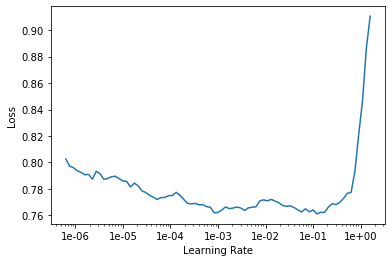

In [161]:
learn.recorder.plot()

In [162]:
learn.fit_one_cycle(3, slice(1e-01), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.706910,0.701816,0.521404,01:01
1,0.694702,0.749323,0.497942,01:00
2,0.690198,0.692883,0.521506,01:00


In [163]:
learn.save('first')

In [164]:
learn.load('first');

In [165]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.688898,0.693596,0.521198,01:04


In [166]:
learn.save('second')

In [167]:
learn.load('second');

In [168]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.689616,0.700129,0.521506,01:15


In [169]:
learn.save('third')

In [170]:
learn.load('third');

In [171]:

learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.686672,0.703343,0.521095,01:21
1,0.678833,0.713382,0.521712,01:21


In [172]:
learn.predict("The market is awesome")

C:\Users\Taru Tak\Anaconda3\envs\fastai_v1\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category down, tensor(0), tensor([0.5008, 0.4992]))

In [176]:
df2 = pd.read_csv(path/'Combined_News_DJIA.csv')

In [177]:
train=df2.iloc[:1500,:]
valid=df2.iloc[1500:,:]

In [178]:
text_columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22']

In [209]:
data_clas = TextDataBunch.from_df(path,train,valid,vocab=data_lm.vocab,text_cols=text_columns,label_cols="Label")

In [210]:
data_clas.show_batch()

text,target
"xxbos b'in xxmaj canada the drug czar slams xxmaj harper gov \ ' t as he exits . "" ... war - on - drugs approach has utterly failed over the past 40 years and must come to an end . xxmaj the emperor truly has no clothes in this case , "" said his e - mail . ' b""remember that ' brave ' attractive looking xxmaj danish woman",1
"xxbos xxmaj australian study : the only effect of legalizing prostitution is an improvement in the health of sex workers xxup breaking - xxup fbi xxmaj arrests 133 xxmaj in xxmaj puerto xxmaj rico xxmaj corruption xxmaj case . xxmaj many xxmaj are xxmaj police xxmaj officers ( 6 xxmaj oct , xxunk ) xxmaj the xxmaj french capital is notorious for its traffic jams . xxmaj now the mayor",1
"xxbos xxmaj germany nixes surveillance pact with xxup us , xxmaj britain "" xxmaj germany canceled a xxmaj cold xxmaj war - era surveillance pact with the xxmaj united xxmaj states and xxmaj britain on xxmaj friday in response to revelations by xxmaj national xxmaj security xxmaj agency leaker xxmaj edward xxmaj snowden about those countries ' alleged electronic eavesdropping operations . "" xxmaj xxunk xxmaj xxunk , a leading",1
"xxbos xxmaj mexico xxmaj bishop xxmaj inspires , xxmaj infuriates by xxmaj telling 1,000s xxmaj gathered in xxmaj stadium xxmaj that xxmaj politicians are xxmaj tied to xxmaj organized xxmaj crime , xxmaj lawmakers ' xxmaj attempts to xxmaj curb xxmaj money xxmaj laundering are xxmaj intentionally xxmaj weak , & & xxmaj new xxmaj labor xxmaj reforms are a xxmaj way to xxmaj enslave xxmaj mexican xxmaj workers xxmaj",0
"xxbos xxmaj guy buys golden egg for $ 13,000 . xxmaj turns out to be a xxmaj xxunk egg worth $ xxunk million . xxmaj tech xxmaj giants xxmaj knew xxmaj about xxmaj prism xxmaj all xxmaj along , the xxup nsa 's xxmaj top xxmaj lawyer xxmaj says xxmaj man in his early 20s ' woke to find xxup mp xxmaj nigel xxmaj xxunk raping him ' xxup bp",1


In [215]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.2,qrnn=True).to_fp16()
learn.load_encoder('fine_tuned_enc')

TypeError: __init__() got an unexpected keyword argument 'qrnn'

In [212]:
data_clas.batch_size=24

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


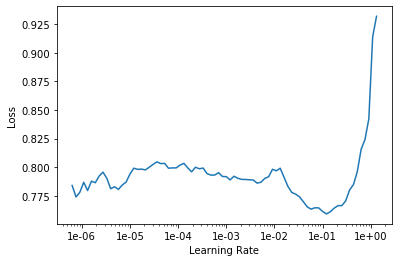

In [213]:
learn.lr_find()

learn.recorder.plot()

In [214]:
learn.fit_one_cycle(2, slice(1e-01/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.755421,0.726816,0.507157,00:57
1,0.712408,0.717857,0.519427,00:58
2,0.706769,0.919210,0.517382,00:59
3,0.687838,0.784167,0.521472,00:58
4,0.681258,0.866543,0.513292,00:59
5,0.669659,0.826727,0.527607,00:59
6,0.668117,0.893303,0.517382,00:58
7,0.638556,0.916577,0.527607,00:59
8,0.627507,0.825645,0.519427,01:00
9,0.606536,0.891556,0.517382,01:01


KeyboardInterrupt: 

In [196]:
learn.save('first')

In [197]:
learn.load('first');

In [207]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


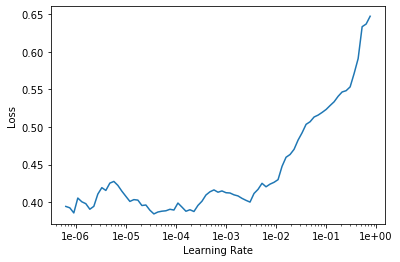

In [208]:
learn.lr_find()

learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5/(2.6**4),1e-4), moms=(0.8,0.7))

In [ ]:
learn.predict("The market is awesome")